## Data

In [1]:
# Load file and take only the second column, which is called "city_ascii" - so simple city names
city_names = [row.split(",")[1].replace('"', "") for row in open("worldcities.csv").readlines()][1:]  # don't take header row

city_names[:10]

['Tokyo',
 'Jakarta',
 'Delhi',
 'Guangzhou',
 'Mumbai',
 'Manila',
 'Shanghai',
 'Sao Paulo',
 'Seoul',
 'Mexico City']

In [105]:
from string import ascii_lowercase
SPACE = " "

# We need a special characters to denote the start and end of a city name
start_end_char = "."
allowed_chars = SPACE + ascii_lowercase
all_chars = start_end_char + allowed_chars

print(f"{ascii_lowercase=}")
print(f"{allowed_chars=}")
print(f"{all_chars=}")

# We will also allow start_end_char
nb_classes = len(all_chars)
print(f"Total num valid chars = {nb_classes}")

ascii_lowercase='abcdefghijklmnopqrstuvwxyz'
allowed_chars=' abcdefghijklmnopqrstuvwxyz'
all_chars='. abcdefghijklmnopqrstuvwxyz'
Total num valid chars = 28


In [40]:
# Clean up the names a little bit
_cities = [name.strip().lower() for name in city_names]

# Remove characters that we don't want to allow
cities = []
for city in _cities:
    clean_city = "".join(ch for ch in city if ch in allowed_chars)
    # print(city, " -> ", clean_city)
    cities.append(clean_city)
    
# Include start/end token
cities = [start_end_char + city + start_end_char for city in cities]
cities[:15]

['.tokyo.',
 '.jakarta.',
 '.delhi.',
 '.guangzhou.',
 '.mumbai.',
 '.manila.',
 '.shanghai.',
 '.sao paulo.',
 '.seoul.',
 '.mexico city.',
 '.cairo.',
 '.new york.',
 '.dhaka.',
 '.beijing.',
 '.kolkata.']

In [41]:
len(cities)

44691

In [42]:
# Lengths of city names
min_len = min(len(c) for c in cities)
max_len = max(len(c) for c in cities)

print(f"Minimum length of city names: {min_len}")
print(f"Maximum length of city names: {max_len}")

Minimum length of city names: 4
Maximum length of city names: 51


## Bigram model

In [43]:
shortest_name = [i for i, c in enumerate(cities) if len(c) == min_len][0]
print(f"Shortest name: {cities[shortest_name]}")

longest_name = [i for i, c in enumerate(cities) if len(c) == max_len][0]
print(f"Shortest name: {cities[longest_name]}")

Shortest name: .bo.
Shortest name: .dolores hidalgo cuna de la independencia nacional.


In [44]:
# Create bigrams over all the city names
all_bigrams = []
bigrams = set()

for city in cities:
    for ch1, ch2 in zip(city[:-1], city[1:]):
        bigram = ch1 + ch2
        if bigram == "..":
            print(f"{city=}, {ch1=}, {ch2=}")
            continue
        all_bigrams.append(bigram)
        bigrams.add(bigram)

In [45]:
print("Total number of bigrams:       ", len(all_bigrams))
print("Total unique bigrams:          ", len(bigrams))
print("Example bigrams in our dataset:", list(bigrams)[:10])

# We have all upper case, lower case and some special characters.
# For now just lower-case everything and remove special characters

# Later on: leave them all in for now because we want to see if the best models
#   are able to also learn the city names should be capitalised etc.

Total number of bigrams:        448609
Total unique bigrams:           751
Example bigrams in our dataset: ['co', 'wn', ' f', 'sp', 'ur', 'rh', 'ot', 'vy', 'dk', '.h']


In [46]:
from collections import Counter

# Most common bigrams:
counter = Counter(all_bigrams)
counter.most_common(10)

# So would expect a model to get high probability to an n or a . after an a.

[('an', 10615),
 ('a.', 8731),
 ('ar', 6768),
 ('ra', 5652),
 ('al', 5288),
 ('.s', 5153),
 ('la', 4919),
 ('n.', 4898),
 ('in', 4698),
 ('e.', 4297)]

In [47]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

In [48]:
# Create simple mapping between each string char and its integer index
stoi = {c:i for i, c in enumerate(all_chars)}
itos = {i:c for c, i in stoi.items()}

In [49]:
print(stoi)

{'.': 0, ' ': 1, 'a': 2, 'b': 3, 'c': 4, 'd': 5, 'e': 6, 'f': 7, 'g': 8, 'h': 9, 'i': 10, 'j': 11, 'k': 12, 'l': 13, 'm': 14, 'n': 15, 'o': 16, 'p': 17, 'q': 18, 'r': 19, 's': 20, 't': 21, 'u': 22, 'v': 23, 'w': 24, 'x': 25, 'y': 26, 'z': 27}


In [50]:
# Tensor to hold counts over each bigram
N = torch.zeros((nb_classes, nb_classes), dtype=torch.int32)

# Perform count over all bigrams
for city in cities:
    for ch1, ch2 in zip(city, city[1:]):
        i = stoi[ch1]
        j = stoi[ch2]
        N[i, j] += 1

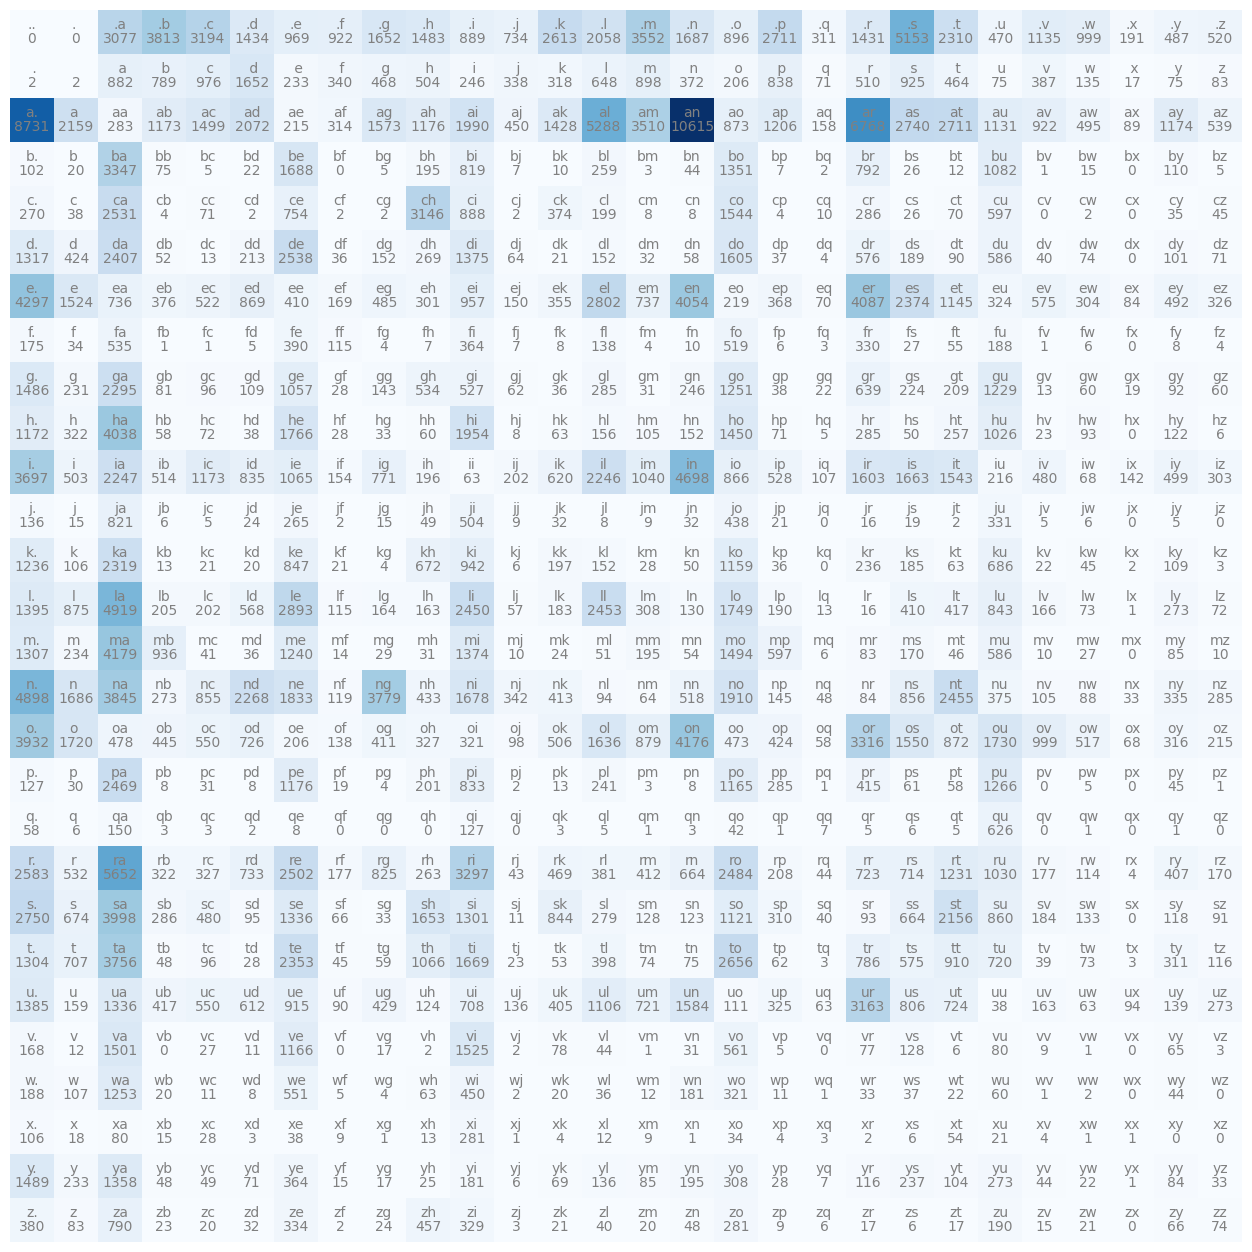

In [51]:
plt.figure(figsize=(16,16))
plt.imshow(N, cmap='Blues')
for i in range(nb_classes):
    for j in range(28):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color='gray')
plt.axis('off');

In [52]:
# Counts over first row where first letter is .
N[0]

tensor([   0,    0, 3077, 3813, 3194, 1434,  969,  922, 1652, 1483,  889,  734,
        2613, 2058, 3552, 1687,  896, 2711,  311, 1431, 5153, 2310,  470, 1135,
         999,  191,  487,  520], dtype=torch.int32)

In [53]:
# Normalise the counts
vals = N[0].float()
probs = vals / vals.sum()
probs

tensor([0.0000, 0.0000, 0.0689, 0.0853, 0.0715, 0.0321, 0.0217, 0.0206, 0.0370,
        0.0332, 0.0199, 0.0164, 0.0585, 0.0460, 0.0795, 0.0377, 0.0200, 0.0607,
        0.0070, 0.0320, 0.1153, 0.0517, 0.0105, 0.0254, 0.0224, 0.0043, 0.0109,
        0.0116])

In [76]:
# Draw a sample from this distribution
g = torch.Generator().manual_seed(313424)
ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
print(f"{ix} -> {itos[ix]}, which had count={N[0, ix]} and prob={probs[ix]:.4f}")

3 -> b, which had count=3813 and prob=0.0853


In [81]:
# Generate now the array of normalised counts to represent confidences (probs)
# We add 1 to each count in order to avoid later on having log(0) for log-probs.
# This is also known as model smoothing, or label smoothing.
P = (N+1).float()
P /= P.sum(axis=1, keepdims=True)

In [80]:
# Check that all rows sum to 1, as a prob density function
P.sum(axis=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000])

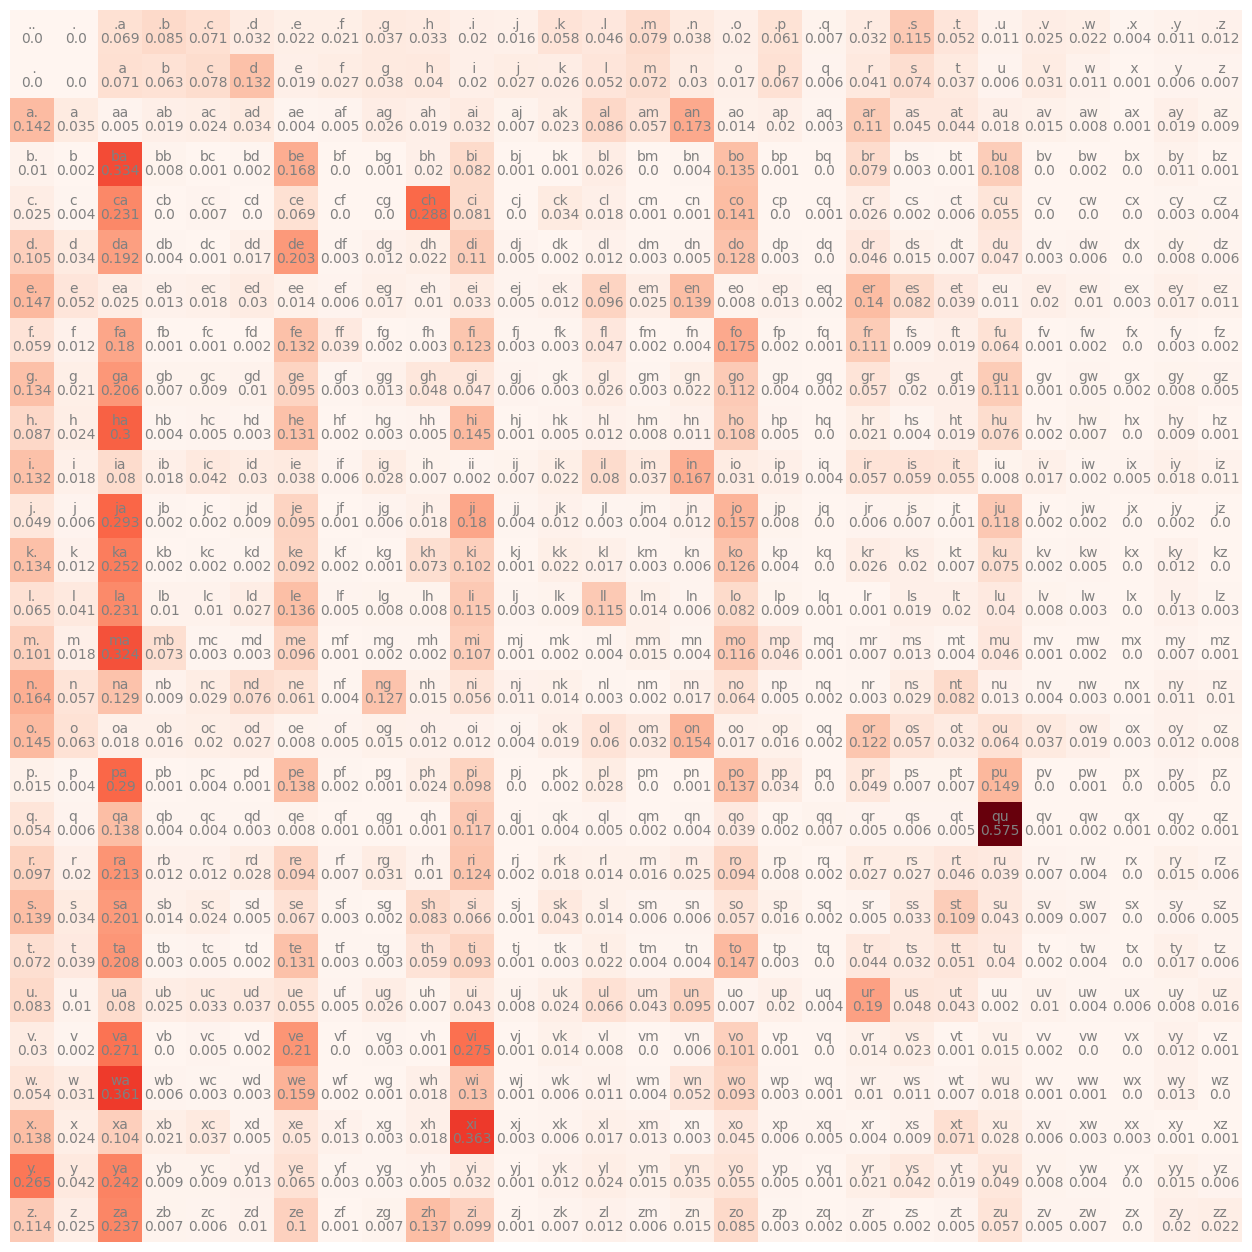

In [106]:
plt.figure(figsize=(16,16))
plt.imshow(P, cmap='Reds')
for i in range(nb_classes):
    for j in range(nb_classes):
        chstr = itos[i] + itos[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color='gray')
        plt.text(j, i, round(P[i, j].item(), 3), ha="center", va="top", color='gray')
plt.axis('off');

# We see some non-zero probabilities for lots of odd combinations like qz due to label smoothing

In [86]:
# Generate some sample city names based on our bag-of-words probability matrix
g = torch.Generator().manual_seed(56713)

nb_samples = 8

for i in range(nb_samples):
    
    # build up a word
    word = []
    ix = 0
    while True:
        # Always start with a start token, as ix initialised as 0
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        char = itos[ix]
        word.append(char)
        if char == start_end_char:
            break
    new_city = "".join(word)
    print(new_city)

maytegangoch.
chasadeven.
dorangchamemulsen st nra.
sansooprderantota.
mch.
lewo.
wesamatixinghu.
derowag.


## Loss

In [91]:
# For MLE, we define the likelihood as the product across the model probilities for a given sequence.
# Multiplying lots of small numbers gives tiny numbers
# Instead, work with log-likelihood, meaning we can then sum instead of multiply.
# Likelihood = a * b * c
# Log-L = log(a) + log(b) + log(c)

# Our likelihood values are in the range [0, 1]
# Log numbers over [0, 1] -♾️ to 0. 
# Summing them up can cover the same range.
# We want to minimise the loss during optimisation (as opposed to maximising).
# ∴ we use negative LL so the sum goes from 0 to ♾️.
# The overall goal is to tweak our model to produce a final NLL loss that equals zero.

In [98]:
# Generate some sample city names based on our bag-of-words probability matrix
g = torch.Generator().manual_seed(56713)

nb_samples = 8

log_likelihood = 0.0
n = 0
for city in cities[:3]:
    for ch1, ch2 in zip(city, city[1:]):
        i = stoi[ch1]
        j = stoi[ch2]
        prob = P[i, j]
        log_prob = torch.log(prob)
        print(f"{ch1}{ch2}: {prob=}, {log_prob=}")
        log_likelihood += log_prob
        n += 1
        
nll = -log_likelihood
        
print(f"{log_likelihood}")
print(f"Negative Log L: {nll}")
print(f"Normalised NLL: {nll/n}")

.t: prob=tensor(0.0517), log_prob=tensor(-2.9627)
to: prob=tensor(0.1473), log_prob=tensor(-1.9152)
ok: prob=tensor(0.0187), log_prob=tensor(-3.9793)
ky: prob=tensor(0.0119), log_prob=tensor(-4.4273)
yo: prob=tensor(0.0549), log_prob=tensor(-2.9018)
o.: prob=tensor(0.1450), log_prob=tensor(-1.9307)
.j: prob=tensor(0.0164), log_prob=tensor(-4.1083)
ja: prob=tensor(0.2933), log_prob=tensor(-1.2267)
ak: prob=tensor(0.0233), log_prob=tensor(-3.7590)
ka: prob=tensor(0.2520), log_prob=tensor(-1.3785)
ar: prob=tensor(0.1104), log_prob=tensor(-2.2036)
rt: prob=tensor(0.0465), log_prob=tensor(-3.0691)
ta: prob=tensor(0.2083), log_prob=tensor(-1.5687)
a.: prob=tensor(0.1424), log_prob=tensor(-1.9489)
.d: prob=tensor(0.0321), log_prob=tensor(-3.4392)
de: prob=tensor(0.2027), log_prob=tensor(-1.5959)
el: prob=tensor(0.0962), log_prob=tensor(-2.3414)
lh: prob=tensor(0.0077), log_prob=tensor(-4.8681)
hi: prob=tensor(0.1455), log_prob=tensor(-1.9279)
i.: prob=tensor(0.1317), log_prob=tensor(-2.0269)


## Convert dataset to one-hot

In [99]:
import torch.nn.functional as F

In [122]:
# Create training samples
xs, ys = [], []

for city in cities:
    for j, (ch1, ch2) in enumerate(zip(city, city[1:])):
        # Convert chars to their integers
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        #print(f"[{city=:<10} sample {j:>2}] {ch1} -> {ch2} -- {ix1} -> {ix2}")
        
        # The first char of the bigram is the input
        xs.append(ix1)
        # The model should target the second letter of the bigram
        ys.append(ix2)
        
xs = torch.tensor(xs)
ys = torch.tensor(ys)

In [124]:
xs[:5]  # Still got integers

tensor([ 0, 21, 16, 12, 26])

In [127]:
xenc = F.one_hot(xs, num_classes=nb_classes).float()  # NN samples must be floats
yenc = F.one_hot(ys, num_classes=nb_classes).float()  # NN samples must be floats

print(f"{xenc.shape=} -- {yenc.shape=}")
print(f"{xenc[:5]=}")

xenc.shape=torch.Size([448609, 28]) -- yenc.shape=torch.Size([448609, 28])
xenc[:5]=tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])


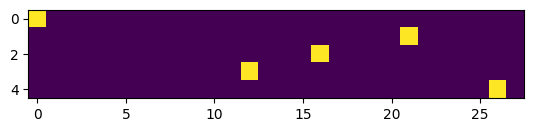

In [126]:
plt.imshow(xenc[:5]);

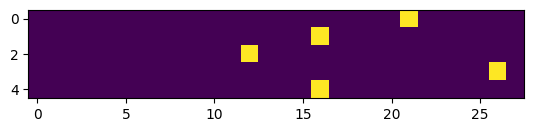

In [128]:
plt.imshow(yenc[:5])

### FC layer 

In [130]:
# Init some weights (no biases included yet)
nb_neurons = nb_classes  # 1
W = torch.randn((nb_classes, nb_neurons))

# Create a model that is only a single linear layer: no bias, no activation -> only a softmax.
logits = xenc @ W  # log counts (this is just an interpretation)
counts = logits.exp()  # Now back to counts
probs = counts / counts.sum(axis=1, keepdims=True)  # Normalises them to be a prob distr
# Previous two lines are simply the softmax

probs.shape

torch.Size([448609, 28])

In [131]:
probs[0]

tensor([0.0483, 0.0041, 0.0620, 0.0388, 0.0118, 0.0120, 0.0074, 0.0166, 0.0268,
        0.0290, 0.0143, 0.0503, 0.0273, 0.0400, 0.1893, 0.0808, 0.0175, 0.0182,
        0.0234, 0.0948, 0.0075, 0.0047, 0.0622, 0.0507, 0.0163, 0.0097, 0.0224,
        0.0139])

In [136]:
probs[:8].sum(1)  # check that output rows sum to 1.0 as we interpret it as a probability distribution

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

In [154]:
# Compute the loss as NLL for each sample, spelled out
nlls = torch.zeros(6)  # 6 is enough to get complete first sample: .tokyo.

for i in range(6):
    # Looking at the i'th bigram - or i'th sample in the dataset
    x = xs[i].item()
    y = ys[i].item()
    
    print("-"*10, f"Bigram {i}", "-"*10)
    print(f"x input:  {x:>2} -> '{itos[x]}'")
    print(f"y target: {y:>2} -> '{itos[y]}'")
    
    print(f"Output prob distribution {probs[i]}")
    print(f"Target output position: {y}")
    p = probs[i, y]
    print(f"Assigned probability: {p.item():.4f}")
    model_pred_ix = torch.argmax(probs[i]).item()
    model_pred_ch = itos[model_pred_ix]
    print(f"Model prediction (most likely): {model_pred_ix=} -> {model_pred_ch=} -> prob={probs[i, model_pred_ix].item():.4f}")
    logp = torch.log(p)
    nll = -logp
    print(f"Log prob:     {logp:>11.6f}")
    print(f"Neg log prob: {nll:>11.6f}")
    nlls[i] = nll    
    
    print()
    
print("=+"*15)
print(f"mean NLL i.e. the loss: {nlls.mean().item():.6f}")

---------- Bigram 0 ----------
x input:   0 -> '.'
y target: 21 -> 't'
Output prob distribution tensor([0.0483, 0.0041, 0.0620, 0.0388, 0.0118, 0.0120, 0.0074, 0.0166, 0.0268,
        0.0290, 0.0143, 0.0503, 0.0273, 0.0400, 0.1893, 0.0808, 0.0175, 0.0182,
        0.0234, 0.0948, 0.0075, 0.0047, 0.0622, 0.0507, 0.0163, 0.0097, 0.0224,
        0.0139])
Target output position: 21
Assigned probability: 0.0047
Model prediction (most likely): model_pred_ix=14 -> model_pred_ch='m' -> prob=0.1893
Log prob:       -5.350087
Neg log prob:    5.350087

---------- Bigram 1 ----------
x input:  21 -> 't'
y target: 16 -> 'o'
Output prob distribution tensor([0.0262, 0.0810, 0.0521, 0.0093, 0.0287, 0.0266, 0.0335, 0.0221, 0.0728,
        0.0475, 0.0061, 0.0383, 0.1413, 0.0057, 0.0086, 0.0138, 0.0379, 0.0172,
        0.0302, 0.0148, 0.0965, 0.0259, 0.0093, 0.0595, 0.0387, 0.0155, 0.0357,
        0.0050])
Target output position: 16
Assigned probability: 0.0379
Model prediction (most likely): model_pred_i

In [ ]:
".tokyo."

# Training
.t   # 10
to   # 130
ok

# Predicting
.  -> g
y  -> o
o  -> m
m  -> .



to
o

##  Optimisation

In [200]:
# Init some weights (no biases included yet)
nb_neurons = nb_classes  # 1
g = torch.Generator().manual_seed(8710)  # reproducibility
# Initialise the weights of our model, our single linear layer:
W = torch.randn((nb_classes, nb_neurons), requires_grad=True, generator=g)

In [201]:
# Forward pass  - copied (inference) code from above:
# Create a model that is only a single linear layer: no bias, no activation -> only a softmax.
logits = xenc @ W  # log counts (this is just an interpretation)
counts = logits.exp()  # Now back to counts
probs = counts / counts.sum(axis=1, keepdims=True) 

# We can now compute the loss - the negative log loss
# We select out the model's predicted probabilities, take the log, take the mean, and make it negative
loss = -probs[torch.arange(xs.shape[0]), ys].log().mean()
print(f"[Run 1] Total loss: {loss:.4f}")

[Run 1] Total loss: 3.7650


In [202]:
# Backward pass
W.grad = None  # sets the gradients to zero; more effcient that manually setting values to a zero tensor
print(f"Before calling backward: {W.grad=}")
loss.backward()
print(f"After calling backward: \n{W.grad[:5, :5]}")

Before calling backward: W.grad=None
After calling backward: 
tensor([[ 1.9261e-02,  2.9107e-03, -6.6382e-04, -4.3507e-03, -4.7293e-03],
        [ 3.1141e-04,  3.0206e-04, -1.3132e-03, -4.6127e-04, -1.3384e-03],
        [-1.4977e-02, -1.5203e-03,  5.2981e-03,  1.6941e-03,  2.5527e-03],
        [-1.0332e-04,  1.1804e-03, -7.1155e-03,  7.2774e-04,  3.5916e-04],
        [-3.0580e-04,  3.6926e-03, -5.3208e-03,  1.7191e-03,  6.1838e-05]])


In [203]:
# Perform the update to the weights according to the provided gradients from backward
lr = 0.1
W.data += -lr * W.grad

In [204]:
# After first run, we had loss 3.7650
# Now we can run another round after having updated W
# (copied from above)
logits = xenc @ W  # log counts (this is just an interpretation)
counts = logits.exp()  # Now back to counts
probs = counts / counts.sum(axis=1, keepdims=True) 
loss = -probs[torch.arange(xs.shape[0]), ys].log().mean()
print(f"[Run 2] Total loss: {loss:.4f}")

[Run 2] Total loss: 3.7644


In [ ]:
# Yay - it is slightly better!

In [210]:
# Put all steps into a single block to loop, performing num_steps gradient descent
num_steps = 500
lr = 20

# Init some weights (no biases included yet)
nb_neurons = nb_classes  # 1
g = torch.Generator().manual_seed(8710)  # reproducibility
# Initialise the weights of our model, our single linear layer:
W = torch.randn((nb_classes, nb_neurons), requires_grad=True, generator=g)

for step in range(num_steps):
    # Forward pass  - copied (inference) code from above:
    # Create a model that is only a single linear layer: no bias, no activation -> only a softmax.
    logits = xenc @ W  # gives log-counts (this is just an interpretation)
    counts = logits.exp()  # Now just to raw counts
    probs = counts / counts.sum(axis=1, keepdims=True)  # normalise to get prob distr

    # We can now compute the loss - the negative log loss (classification problem!)
    # We select out the model's predicted probabilities, take the log, take the mean, and make it negative
    loss = -probs[torch.arange(xs.shape[0]), ys].log().mean()
    if step % 20 == 0:
        print(f"[{step:>2}] Total loss: {loss:.4f}")

    # Backward pass
    W.grad = None  # sets the gradients to zero; more effcient that manually setting values to a zero tensor
    loss.backward()

    # Perform the update to the weights according to the provided gradients from backward
    W.data += -lr * W.grad

# It is working :)

[ 0] Total loss: 3.7650
[20] Total loss: 2.9137
[40] Total loss: 2.7737
[60] Total loss: 2.7244
[80] Total loss: 2.7005
[100] Total loss: 2.6869
[120] Total loss: 2.6783
[140] Total loss: 2.6724
[160] Total loss: 2.6682
[180] Total loss: 2.6651
[200] Total loss: 2.6626
[220] Total loss: 2.6607
[240] Total loss: 2.6591
[260] Total loss: 2.6578
[280] Total loss: 2.6567
[300] Total loss: 2.6558
[320] Total loss: 2.6550
[340] Total loss: 2.6543
[360] Total loss: 2.6536
[380] Total loss: 2.6531
[400] Total loss: 2.6526
[420] Total loss: 2.6521
[440] Total loss: 2.6517
[460] Total loss: 2.6514
[480] Total loss: 2.6510


In [212]:
# Same again, but add a regularisation term: magnitude of W
# This is equivalent in the count-based model, where we added label smoothing i.e. (W+1).log(). The +1
# This regularisation is encouraging the values in W to become more uniform
# Also encouraging them to be zero, as that means W.exp().softmax() would give uniform probs


# Put all steps into a single block to loop, performing num_steps gradient descent
num_steps = 500
lr = 30
reg_weight = 0.1  # NEW HERE

# Init some weights (no biases included yet)
nb_neurons = nb_classes  # 1
g = torch.Generator().manual_seed(8710)  # reproducibility
# Initialise the weights of our model, our single linear layer:
W = torch.randn((nb_classes, nb_neurons), requires_grad=True, generator=g)

for step in range(num_steps):
    # Forward pass  - copied (inference) code from above:
    # Create a model that is only a single linear layer: no bias, no activation -> only a softmax.
    logits = xenc @ W  # gives log-counts (this is just an interpretation)
    counts = logits.exp()  # Now just to raw counts
    probs = counts / counts.sum(axis=1, keepdims=True)  # normalise to get prob distr

    # We can now compute the loss - the negative log loss (classification problem!)
    # We select out the model's predicted probabilities, take the log, take the mean, and make it negative
    reg_term = (W**2).mean()
    loss = -probs[torch.arange(xs.shape[0]), ys].log().mean() + reg_weight * reg_term
    if step % 20 == 0:
        print(f"[{step:>2}] Total loss: {loss:.4f}")

    # Backward pass
    W.grad = None  # sets the gradients to zero; more effcient that manually setting values to a zero tensor
    loss.backward()

    # Perform the update to the weights according to the provided gradients from backward
    W.data += -lr * W.grad

# It is working... but loss decreases more slowly, as we are adding a reg. loss term
# Even increasing the LR, optimisation converges at a worse loss with the reg term
# Might expect this model to generalise better - not allowed to overfit as far.

[ 0] Total loss: 3.8640
[20] Total loss: 2.8868
[40] Total loss: 2.8025
[60] Total loss: 2.7794
[80] Total loss: 2.7702
[100] Total loss: 2.7657
[120] Total loss: 2.7632
[140] Total loss: 2.7618
[160] Total loss: 2.7610
[180] Total loss: 2.7605
[200] Total loss: 2.7601
[220] Total loss: 2.7599
[240] Total loss: 2.7598
[260] Total loss: 2.7597
[280] Total loss: 2.7596
[300] Total loss: 2.7596
[320] Total loss: 2.7595
[340] Total loss: 2.7595
[360] Total loss: 2.7595
[380] Total loss: 2.7595
[400] Total loss: 2.7595
[420] Total loss: 2.7595
[440] Total loss: 2.7595
[460] Total loss: 2.7595
[480] Total loss: 2.7595


## Inference

In [230]:
# Sample from the trained model
g = torch.Generator().manual_seed(42)

for i in range(1):
    
    out = []
    ix = 0
    
    while True:
        # Before: using the count-based bigram model
        probs_ = P[ix]
        
        # Now: using the gradient optimised single linear layer model
        # Convert our current index into a one-hot encoding, allowing us to use it in forward pass
        onehot_input = F.one_hot(torch.tensor([ix]), num_classes=nb_classes).float()
        logit = onehot_input @ W  # This is "running the model"
        counts = logit.exp()  # Converts into prob distr.
        probs = counts / counts.sum(dim=1, keepdims=True)

        print(f"Count based:  {torch.argmax(probs_)}")
        print(f"Linear layer: {torch.argmax(probs)}")

        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        letter = itos[ix]
        out.append(letter)

        if letter == start_end_char:
            break

    new_city = "".join(out)
    print(f"{new_city=}")
        
# The produced words are exactly the same!  (random seed is important to emphasise this)
# The actuall probabilities are not identical!

# The two models encapsulate the same information: just the counts to give likelihood of next letter.
# We arrived at the same model in two different ways
# Important to note that the count based model does not scale
# The NN is way more flexible.
# Even though we are really only changing the single line: logit = xenc @ W
# The rest stays the same!

Count based:  20
Linear layer: 20
Count based:  2
Linear layer: 2
Count based:  15
Linear layer: 15
Count based:  2
Linear layer: 2
Count based:  9
Linear layer: 9
Count based:  2
Linear layer: 2
Count based:  15
Linear layer: 15
Count based:  2
Linear layer: 2
Count based:  0
Linear layer: 0
new_city='barchirn.'
